In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import itertools
import os 
from PIL import Image
from matplotlib import pyplot as plt
import yaml
import requests
import time
import src
from typing import List, Tuple
import matplotlib.pyplot as plt
import src
from src import PATHS, Dotdict
from debias_clip_utils import BiasClassifier, load_occ1_data, fairness_intervention_ranking

loading annotations into memory...


## Load model

In [2]:
data_dir = 'data/Occupation1/google'
gender_occ_df = pd.read_csv('data/Occupation1/gender_labelled_images.csv')

with open('model.yml') as f:
    # use safe_load instead load
    debias_cfg = yaml.safe_load(f)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
debias_cfg['DEVICE'] = device

debias_model = src.models.DebiasCLIP.from_cfg(debias_cfg)
model, _preprocess, tokenizer, model_alias = debias_model
model = model.float()
model.clip = model.clip.float()

bias_classifier = BiasClassifier(512, n_class=3, hidden_size=64)

In [4]:
image_features, text_features, attrs = load_occ1_data(gender_occ_df, data_dir, model, tokenizer=tokenizer, transform=_preprocess, device=device)

3262it [00:22, 145.52it/s]


In [5]:
# compute similarity matrix for retrieval
image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
text_features_norm  = text_features / text_features.norm(dim=-1, keepdim=True)
image_features_np = image_features_norm.cpu().numpy()
text_features_np = text_features_norm.cpu().numpy()
sim = text_features_np @ image_features_np.T

In [6]:
adv_model = BiasClassifier(512, n_class=3, hidden_size=64)

model_path = "./saved_models/"
model_name = "Bias_classifier_1"
save_path = os.path.join(model_path, model_name)

adv_model.load_state_dict(torch.load(os.path.join(save_path, f"{model_name}_final_{29}.pt")))

<All keys matched successfully>

## Infer psuedo labels

In [7]:
# infer predicted genders
adv_model.zero_grad()
adv_model.eval()
adv_model.to(device)
output = adv_model(image_features)
_, pred = output.data[:, 1:].cpu().topk(1, dim=1)
psuedo_gender_labels = pred

psuedo_gender_labels2 = psuedo_gender_labels + 1
psuedo_gender_labels2 = psuedo_gender_labels2[:, 0].data.numpy()
gt_gender_labels = attrs.cpu().data.numpy()

In [8]:
pred_fem = psuedo_gender_labels2[np.where(gt_gender_labels == 2)[0]]
true_fem = gt_gender_labels[np.where(gt_gender_labels == 2)[0]]

pred_male = psuedo_gender_labels2[np.where(gt_gender_labels == 1)[0]]
true_male = gt_gender_labels[np.where(gt_gender_labels == 1)[0]]

gender_acc = np.sum(psuedo_gender_labels2 == gt_gender_labels)/len(gt_gender_labels)
print("Total Accuracy: {}".format(gender_acc))
print("Accuracy on male: {}".format(np.sum(pred_fem == true_fem)/len(true_fem)))
print("Accuracy on female: {}".format(np.sum(pred_male == true_male)/len(true_male)))

Total Accuracy: 0.9322501532801962
Accuracy on male: 0.8755905511811024
Accuracy on female: 0.9683734939759037


## Evaluate retrieval performance and bias 

In [9]:
# Evaluate retrieval performance and bias 
top_n = 100

result_bias = []
occupt_ret_gender_dict_original = dict()
occupt_ret_relevance_dict_original = dict()

for idx, e_occup in enumerate(gender_occ_df['search_term'].unique()):
    ret_list = sim[idx].argsort()[::-1][:top_n]
    num_occup = gender_occ_df[gender_occ_df['search_term'] == e_occup].shape[0]
    
    ret_df = gender_occ_df.iloc[ret_list[:top_n]]
    
    occupt_ret_gender_dict_original[e_occup] = [1 if e_gen=='man' else 0 for e_gen in ret_df.image_gender]
    occupt_ret_relevance_dict_original[e_occup] = [1 if e_occ==e_occup else 0 for e_occ in ret_df.search_term]

    pos_pred = ret_df[ret_df['search_term'] == e_occup].shape[0]
    
    precision = pos_pred / top_n
    
    N_male = ret_df[ret_df['image_gender'] == 'man'].shape[0]
    N_fem = ret_df[ret_df['image_gender'] == 'woman'].shape[0]
    bias = (N_male - N_fem)/(N_male + N_fem)
    result_bias.append((e_occup, precision, bias))
    #print("Occupation: {}, Recall: {}, Bias(male-fem): {}".format(e_occup, recall, bias))
    #break
    
#top_n = 20
gender_labels = psuedo_gender_labels2
result_debias = []
occupt_ret_gender_dict_ours = dict()
occupt_ret_relevance_dict_ours = dict()

for idx, e_occup in enumerate(gender_occ_df['search_term'].unique()):
    ret_list = fairness_intervention_ranking(sim, idx, gender_labels, top_n)
    ret_df = gender_occ_df.iloc[ret_list[:top_n]]
    occupt_ret_gender_dict_ours[e_occup] = [1 if e_gen=='man' else 0 for e_gen in ret_df.image_gender]
    occupt_ret_relevance_dict_ours[e_occup] = [1 if e_occ==e_occup else 0 for e_occ in ret_df.search_term]

    pos_pred = ret_df[ret_df['search_term'] == e_occup].shape[0]
    
    precision = pos_pred / top_n
    
    N_male = ret_df[ret_df['image_gender'] == 'man'].shape[0]
    N_fem = ret_df[ret_df['image_gender'] == 'woman'].shape[0]
    bias = (N_male - N_fem)/(N_male + N_fem)
    
    result_debias.append((e_occup, precision, bias))

occup_list = [e_t[0] for e_t in result_bias]
bias1_list = [e_t[2] for e_t in result_bias]
prec1_list = [e_t[1] for e_t in result_bias]

bias2_list = [e_t[2] for e_t in result_debias]
prec2_list = [e_t[1] for e_t in result_debias]


In [ ]:
### Visualization and 

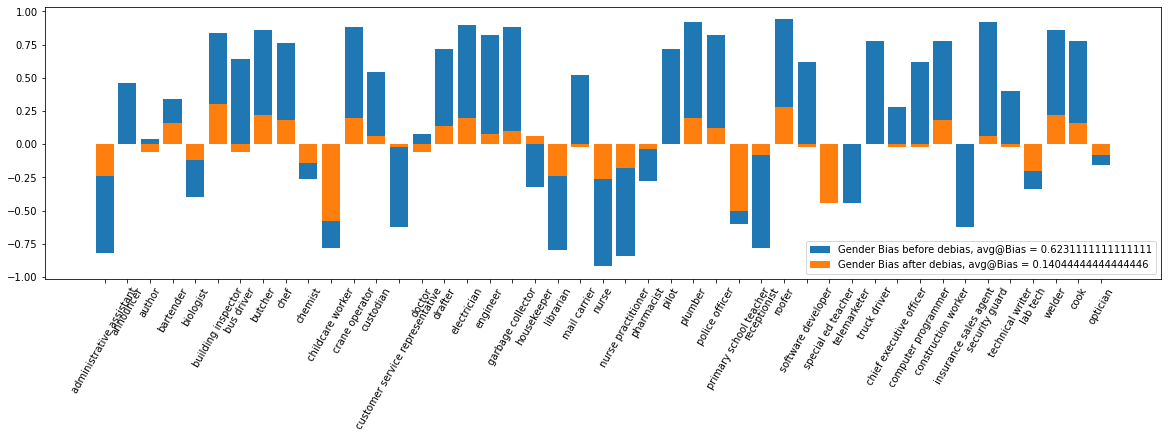

In [10]:
%matplotlib inline

plt.figure(figsize=(20, 5))
plt.bar(occup_list, bias1_list, label='Gender Bias before debias, avg@Bias = {}'.format(np.mean(np.abs(bias1_list))))
plt.bar(occup_list, bias2_list, label='Gender Bias after debias, avg@Bias = {}'.format(np.mean(np.abs(bias2_list))))

plt.xticks(rotation=60)
plt.legend()
plt.show()

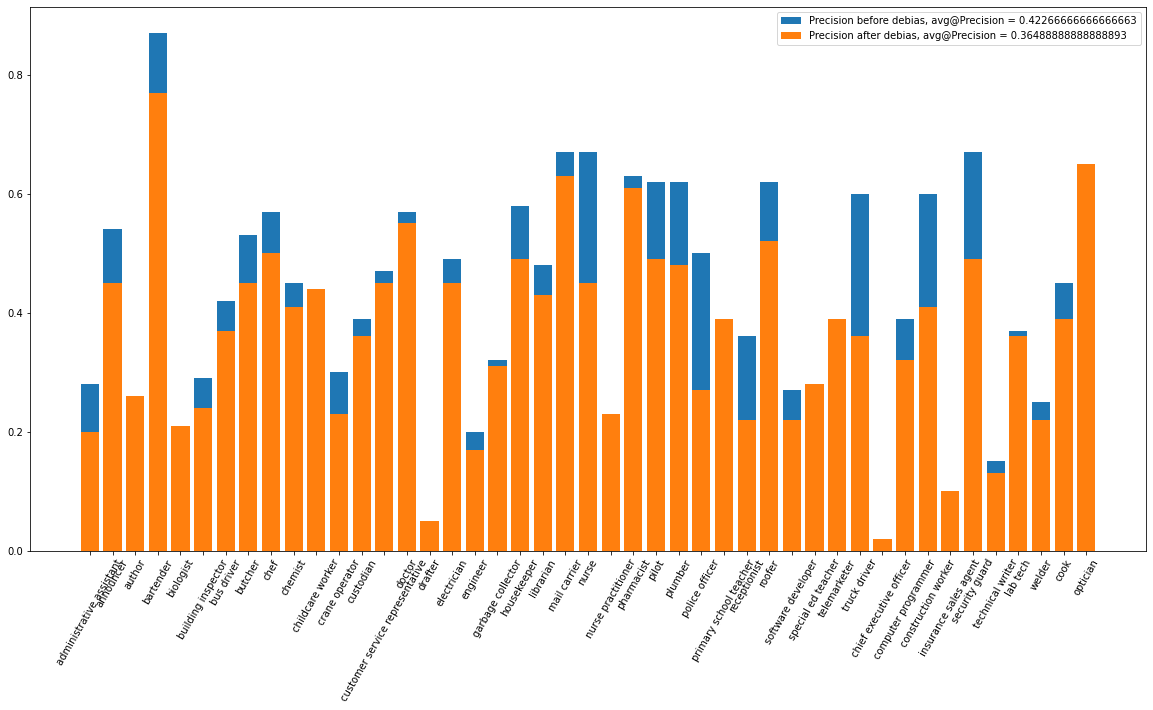

In [11]:
plt.figure(figsize=(20, 10))
plt.bar(occup_list, prec1_list, label='Precision before debias, avg@Precision = {}'.format(np.mean(prec1_list)))
plt.bar(occup_list, prec2_list, label='Precision after debias, avg@Precision = {}'.format(np.mean(prec2_list)))

plt.xticks(rotation=60)
plt.legend()
plt.show()

In [12]:
from debias_clip_utils import mean_precision, mean_average_precision, mndcg_k, meanBias, mean_dcg_weight_bias

In [13]:
# for all queries(occupations)
top_n = 100
print("Original CLIP: ")
org_rs = [occupt_ret_relevance_dict_original[e_key] for e_key in occupt_ret_relevance_dict_original.keys()]
print('mP@K: {}'.format(mean_precision(org_rs, top_n)))
print('mAP@K: {}'.format(mean_average_precision(org_rs, top_n)))
print('mNDCG@K: {}'.format(mndcg_k(org_rs, top_n)))
print('-'*20)
print("Ours: ")
ours_rs = [occupt_ret_relevance_dict_ours[e_key] for e_key in occupt_ret_relevance_dict_ours.keys()]
print('mP@K: {}'.format(mean_precision(ours_rs, top_n)))
print('mAP@K: {}'.format(mean_average_precision(ours_rs, top_n)))
print('mNDCG@K: {}'.format(mndcg_k(ours_rs, top_n)))
print('-'*20)



Original CLIP: 
mP@K: 0.42266666666666663
mAP@K: 0.6497362525303043
mNDCG@K: 0.8562620786183044
--------------------
Ours: 
mP@K: 0.36488888888888893
mAP@K: 0.5553673405334266
mNDCG@K: 0.8161797374697727
--------------------


In [14]:
# for all queries(occupations)
top_n = 100
print("Original CLIP: ")
org_bias_list = [2* (np.asarray(occupt_ret_gender_dict_original[e_occup])-0.5) for e_occup in occupt_ret_gender_dict_original.keys()]
print('mBias@K: {}'.format(meanBias(org_bias_list, top_n)))
print('mNDCG*Bias@K: {}'.format(mean_dcg_weight_bias(org_bias_list, top_n)))
print('-'*20)

print("Ours: ")
ours_bias_list = [2* (np.asarray(occupt_ret_gender_dict_ours[e_occup])-0.5) for e_occup in occupt_ret_gender_dict_ours.keys()]
print('mBias@K: {}'.format(meanBias(ours_bias_list, top_n)))
print('mNDCG*Bias@K: {}'.format(mean_dcg_weight_bias(ours_bias_list, top_n)))
print('-'*20)


Original CLIP: 
mBias@K: 0.6231111111111111
mNDCG*Bias@K: 0.1408544472435563
--------------------
Ours: 
mBias@K: 0.14044444444444446
mNDCG*Bias@K: 0.03344958534246716
--------------------
